# Import packages and set settings

In [1]:
%load_ext autoreload
%autoreload 2

import sys
# sys.path.insert(1, './python_mods/')
sys.path.insert(1, '../../python_modules')
import plotting
import model_supp 
import model
import saving
import h5py

In [2]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import os
import collections

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Functions

# Model

## Model Functions

## Model Variables (Constants)

In [7]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)
# steps = 3001
time2 = np.linspace(0,dt*3001,steps)

MAP3K_t = model_supp.molarity_conversion(123+1207+1611) #ssk2+ssk22+ste11
MAP2K_t = model_supp.molarity_conversion(4076)
MAPK_t = model_supp.molarity_conversion(8225)
PTP_t = model_supp.molarity_conversion(443+1324) # ptp2+ptp3

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = model_supp.molarity_conversion(118+400) # start with all on


labelnames = ['$- fb$', '$+ fb$', '$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$',
              '$k_2$', '$k_4$', '$k_6$', '$d_1$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$']


minimums = [-4, -4, -4,
        -4, -4, -4, -4,
        -4, -4, -4, -4, 
        -4, -4, -4, 
        -4, -4, -4]

maximums = [ 4, 4, 4, 
        4, 4, 4, 4,
        4, 4, 4, 4, 
        4, 4, 4,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums) #for plotting
dims = (diff, minimums) #for plotting

initials = [MAP3K, MAP2K, MAPK, gly]

params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 

doses = [150000, 550000]
wt_doses = [150000, 550000]
t100a_doses = [150000, 550000]

# Load experimental data

In [8]:
exp_data, exp_time = model_supp.get_data()

mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data, hog1_ramp_inhib_data, pbs2_ramp_data, mapk_ptpD_data = exp_data
mapk_time, mapk_time_t100a_long, mapk_ramp_time = exp_time 

mapk_data_t100a_0 = [mapk_t100a_data[0]] 
mapk_time_t100a_0 = [0, 30, 60, 90, 120, 150, 180, 240, 300]

mapk_t100a_data = [mapk_t100a_data[1], mapk_t100a_data[2]] # exculde 0 because different timescale

# Load simulation data

In [9]:
model_fxns = model.Model(model.M2c_kb, model.simulate_t100a_experiment_M2a_kb, model.simulate_nopos_experiment_M2a_kb, model.M2c_kb_on_off)

In [122]:
def get_datad():
    # wt_folder = '/nas/longleaf/home/sksuzuki/MAPK_activation/WT'
    # t100a_folder = '/nas/longleaf/home/sksuzuki/MAPK_activation/T100A'
    # pbs2_folder = '/nas/longleaf/home/sksuzuki/MAPK_activation/Pbs2'
    # pbs2_t100a_folder = '/nas/longleaf/home/sksuzuki/MAPK_activation/Pbs2_T100A'
    # # ramp_folder = '/nas/longleaf/home/sksuzuki/HOG_model/data/MAPK activation/ramp_1'
    # ptpD_folder = '/nas/longleaf/home/sksuzuki/MAPK_activation/ptpD'

    base = '/pine/scr/j/m/jmcgirr/sksuzuki/MAPK_activation'
    wt_folder = base + '/WT'
    t100a_folder = base + '/T100A'
    pbs2_folder = base + '/Pbs2'
    pbs2_t100a_folder = base + '/Pbs2_T100A'
    # hog1_ramp_folder = base + '/ramp_1'
    ptpD_folder = base + '/ptpD'

    wt_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK_activation/WT'
    t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK_activation/T100A'
    pbs2_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK_activation/Pbs2'
    pbs2_t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK_activation/Pbs2_T100A'
    # ramp_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ramp_1'
    ptpD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK_activation/ptpD'

    mapk_time, mapk_wt_data = load_csv_data(wt_folder)
    mapk_time, mapk_t100a_data = load_csv_data(t100a_folder)
    # mapk_data_t100a_long = [mapk_t100a_data[0]]
    mapk_time_t100a_long = [0, 30, 60, 90, 120, 150, 180, 240, 300]

    mapk_time, map2k_wt_data = load_csv_data(pbs2_folder)
    mapk_time, map2k_t100a_data = load_csv_data(pbs2_t100a_folder)
    # mapk_ramp_time, hog1_ramp_data = load_csv_data(hog1_ramp_folder)
    mapk_time, mapk_ptpD_data = load_csv_data(ptpD_folder)
    # mapk_time, sho1_wt_data = load_csv_data(ssk1D_folder)
    # mapk_time, sln1_wt_data = load_csv_data(sho1DD_folder)
    data = [mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, [], mapk_ptpD_data]
    time = [mapk_time, mapk_time_t100a_long, []]
    return data, time

def calc_sim_score(model_fxns, params, exp_data, exp_time, total_protein, inits, ptpD=True):
#     params = convert_individual(learned_params, arr_conversion_matrix, number_of_params)
    # mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data, mapk_ptpD_data = data
    # mapk_data_t100a_long = [mapk_t100a_data[0]]
    # mapk_time, mapk_time_t100a_long, mapk_ramp_time = exp_time
    # hog1_doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
    wt_doses = [150000,550000]
    t100a_doses = [0, 150000,550000]


    # exp_data, exp_time = get_data()

    mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data, mapk_ptpD_data = exp_data
    mapk_time, mapk_time_t100a_long, mapk_ramp_time = exp_time

    mapk_data_t100a_0 = [mapk_t100a_data[0]]
    mapk_time_t100a_0 = [0, 30, 60, 90, 120, 150, 180, 240, 300]

    # mapk_t100a_data = [mapk_data_t100a_0, mapk_t100a_data[1], mapk_t100a_data[2]]

    wt_ss_inits = model.run_ss(model_fxns.m, inits, total_protein, params)

    dt = 0.1
    steps = 601
    time = np.linspace(0,dt*steps,steps)
    time_long = np.linspace(0,dt*3001,steps)

    closest_idxs_mapk = [np.abs(time - t).argmin() for t in mapk_time]
    closest_idxs_t100a_long = [np.abs(time_long - t).argmin() for t in mapk_time_t100a_0]
    closest_idxs_ramp_time = [np.abs(time - t).argmin() for t in mapk_ramp_time]

    # mse_total = 0
        # ptpDs
    if ptpD:
        mses = np.zeros(23)
        ptp_doses = [0, 150000, 350000, 550000]
        ptpD_total_protein = total_protein[:-1] + [0]
        ptpD_inits = inits[:-1] + [0]

        ptpD_ss_inits = model.run_ss(model_fxns.m, ptpD_inits, ptpD_total_protein, params)
        # ptpD_ss_inits = model.run_ss_ptps(model_fxns.m, inits, total_protein, params)

        for i, (dose, data) in enumerate(zip(ptp_doses, mapk_ptpD_data), 19):
            odes = model.simulate_wt_experiment(model_fxns.m, ptpD_ss_inits, ptpD_total_protein, dose, params, time)
            # odes = model.simulate_ptpD_experiment(model_fxns.m, ptpD_ss_inits, total_protein, dose, params, time)
            mapk = odes[:,2]/total_protein[2]*100
            mses[i] = ((data - mapk[closest_idxs_mapk])**2).mean()
            # mse_total += mses[i]

    # WILDTYPE
    # Hog1
    else:
        mses = np.zeros(19)

    for i, (dose, data) in enumerate(zip(wt_doses, mapk_wt_data), 0):
        odes = model.simulate_wt_experiment(model_fxns.m, wt_ss_inits, total_protein, dose, params, time)#mapk_time)
        mapk = odes[:,2]/total_protein[2]*100
        mses[i] = ((data - mapk[closest_idxs_mapk])**2).mean()
        # mse_total += mses[i]

        # Pbs2
        if dose == 150000:
            map2k = odes[:,1]/total_protein[1]*100
            mses[14] = ((map2k_wt_data[0] - map2k[closest_idxs_mapk])**2).mean()
            # mse_total += mses[14]
        elif dose == 550000:
            map2k = odes[:,1]/total_protein[1]*100
            mses[15] = ((map2k_wt_data[1] - map2k[closest_idxs_mapk])**2).mean()
            # mse_total += mses[15]
#     (mse_total/63)

    # ANALOG SENSITIVE
    # Hog1
    for i, (dose, data) in enumerate(zip(t100a_doses, mapk_t100a_data), 7):
        if dose == 0:
            odes = model_fxns.t100a(model_fxns.m, wt_ss_inits, total_protein, dose, params, time_long)
            mapk = odes[:,2]/total_protein[2]*100
            mses[i] = ((data - mapk[closest_idxs_t100a_long])**2).mean()
            # mse_total += mses[i]
        else:
            odes = model_fxns.t100a(model_fxns.m, wt_ss_inits, total_protein, dose, params, time)
            mapk = odes[:,2]/total_protein[2]*100
            mses[i] = ((data - mapk[closest_idxs_mapk])**2).mean()
            # mse_total += mses[i]
            # Pbs2
            if dose == 150000:
                map2k = odes[:,1]/total_protein[1]*100
                mses[16] = ((map2k_t100a_data[0] - map2k[closest_idxs_mapk])**2).mean()
                # mse_total += mses[16]
            elif dose == 550000:
                map2k = odes[:,1]/total_protein[1]*100
                mses[17] = ((map2k_t100a_data[1] - map2k[closest_idxs_mapk])**2).mean()
                # mse_total += mses[17]
    # print(mses, mse_total)
#    (mse_total/69)

    # Hog1 ramp
    mses[18] = 0
#     for data in hog1_ramp_data:
#         odes = model.simulate_wt_experiment(model_fxns.m, wt_ss_inits, total_protein, 0, params, time, run_type=['ramp'])
#         mapk = odes[:,2]/total_protein[2]*100
#         mses[18] = ((data - mapk[closest_idxs_ramp_time])**2).mean()
# #     (mse_total/13)
    #     (mse_total/27)
    # print(mses)
    # print(np.sum(mses[:18]))
    return mses

def load_csv_data(folder):
    data = []
    for csv in pathlib.Path(folder).glob('*.csv'):
        f_data = pd.read_csv(csv)
        time = f_data['Time'].tolist()
        f_data=f_data.set_index('Time')
        f_data = f_data.mean(axis=1)
        f_data = f_data.tolist()
        data.append(f_data)
    return time, data

dada, dtime = get_datad()

def recalc_mses(model_fxns, EA_theta_set, exp_data, exp_time, params_constants, initials, ptpD=False):
    mses = []
    for params in EA_theta_set:
        mses.append(sum(model_supp.calc_sim_score(model_fxns, params, exp_data, exp_time, params_constants, initials, ptpD=False)[:18]))
#     re_idx = sorted(range(len(mses)), key=lambda k: mses[k])
#     thetas = EA_theta_set[re_idx]
#     mses = np.sort(mses)
    return mses, thetas

# test = []
# for params in sorted_thetas_EA[:10]:
#     test.append(sum(calc_sim_score(model_fxns, params, dada, dtime, params_constants, initials, ptpD=True)[:18]))
#     test.append(calc_sim_score(model_fxns, params, dada, dtime, params_constants, initials, ptpD=False))
mses, thetas = recalc_mses(model_fxns, sorted_thetas_EA[:10], dada, dtime, params_constants, initials, ptpD=False)
#     test.append()
print(mses)

dea_mses, dea_thetas = model_supp.sort_mses_thetas(ea_mses, ea_thetas)
mses, thetas = recalc_mses(model_fxns, ea_thetas[:10], dada, dtime, params_constants, initials, ptpD=False)

print(mses)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


[567.4997838914837, 660.7329436926306, 674.5842212641006, 733.5425243715933, 734.5328510488246, 776.8006623522549, 784.4381036869025, 785.7918098715452, 789.3675444496387, 803.4048065803217]


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2283.343000982888, 1397.7806661193395, 1639.3358016109623, 1956.3454824564712, 2293.418835874484, 2135.180448075582, 1547.9395740260939, 2130.1423816326956, 2354.9899386477427, 1274.044616246178]


In [134]:
print(np.array(ea_thetas[:1]))

last_params[:1]

[[2.74160876e-04 3.26008646e-01 1.70776644e+01 1.07481413e-03
  8.15222346e+00 1.38506142e+00 6.04469702e-02 5.63716257e-01
  3.25086048e+01 1.32636407e+03 1.66043688e-03 4.86241963e-03
  1.00000000e-04 1.00000000e-04 3.40172209e-03 3.62077158e+00
  2.41884049e+03]]


array([[1.00545116e-04, 1.00000000e-04, 1.00000000e+04, 4.68456063e-01,
        2.16853298e+02, 4.06837175e+00, 3.96936106e-03, 1.55670718e+01,
        1.00000000e+04, 2.08656467e-02, 2.78748077e-03, 3.60834295e+03,
        8.04573501e-01, 7.05215723e-01, 8.66212806e-01, 1.93375189e+03,
        1.00000000e-04]])

In [12]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/200301_M2c/'

all_params, last_params, all_mses, last_mses = model_supp.get_sim_data(folder, num_sims=2000)

Number of runs collected: 1999
Best last gen MSE: 567.499603975699
Mean last gen MSEs of top 5%: 919.566340189717


In [94]:
## sort
sorted_mses_EA, sorted_thetas_EA = model_supp.sort_mses_thetas(last_mses, last_params)

In [68]:
test = model_supp.calc_sim_score(model_fxns, sorted_thetas_EA[0], params_constants, initials)
print(test[:18])
sum(test[:18])

105.3595487604895
[  59.96892244  118.18781904    0.            0.            0.
    0.            0.         1062.92505653   66.10989544  194.64203323
    0.            0.            0.            0.           26.74488466
   29.52553848   70.20716436   20.94243481]


1649.2537490001098

# Check EA results

No handles with labels found to put in legend.


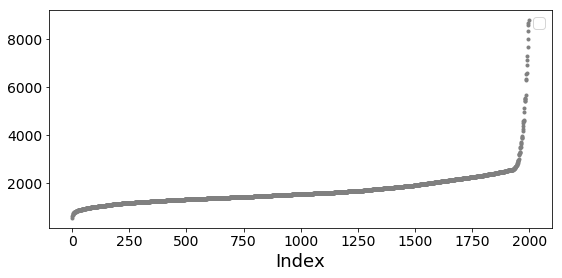

In [14]:
plotting.plt_idx_vs_mse(sorted_mses_EA, len(sorted_mses_EA))

No handles with labels found to put in legend.


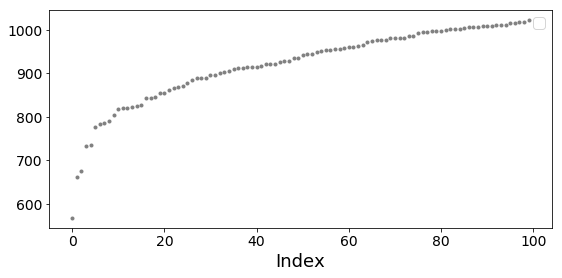

In [15]:
plotting.plt_idx_vs_mse(sorted_mses_EA, 100)

<Figure size 720x576 with 0 Axes>

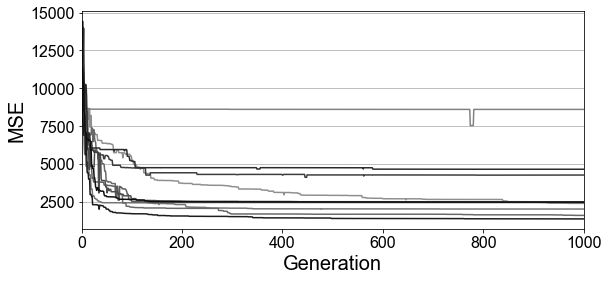

In [47]:
plotting.plt_mses_gen(1000,all_mses,10)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

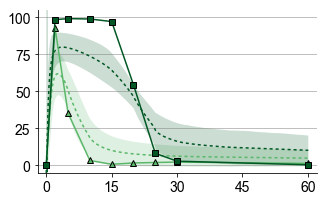

In [16]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA, params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
../../python_modules\model.py:525: RuntimeWarning: divide by zero encounte

Dose: 0 complete.


<Figure size 720x576 with 0 Axes>

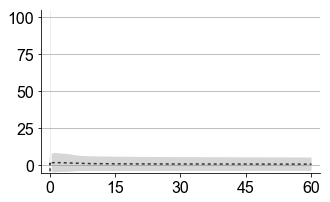

In [19]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA, params_constants, initials,  [0], time, 2,
                        exp_data=None, exp_time=None, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

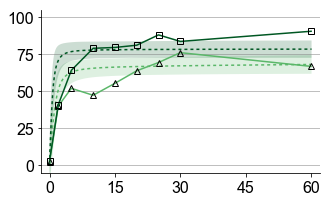

In [21]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA, params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:2

Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

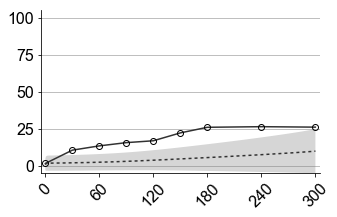

In [23]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA, params_constants, initials,  [0], time2, 2,
                        exp_data=mapk_data_t100a_0, exp_time=mapk_time_t100a_0, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

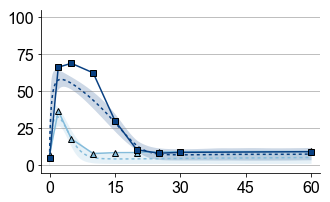

In [27]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:100], params_constants, initials,  wt_doses, time, 1,
                        exp_data=map2k_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

Dose: 150000 complete.
Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

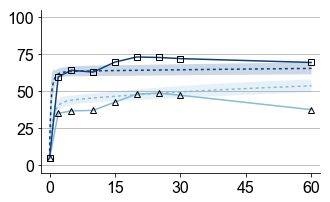

In [29]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:10], params_constants, initials,  wt_doses, time, 1,
                        exp_data=map2k_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

<Figure size 720x576 with 0 Axes>

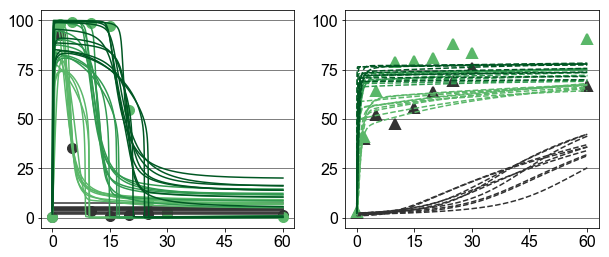

In [30]:
# original parameter values
plotting.plt_param_behaviors(model_fxns, sorted_thetas_EA, 10, params_constants, initials,  [0, 150000, 350000, 550000], time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

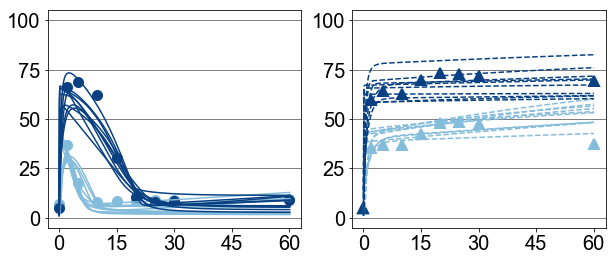

In [18]:
plotting.plt_param_behaviors(model_fxns, sorted_thetas_EA, 10, params_constants, initials,  [150000,550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

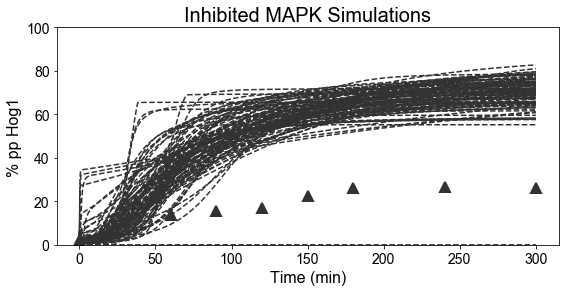

In [25]:
mapk_time_t100a_long = [0, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(model_fxns, sorted_thetas_EA, 100, params_constants, initials, mapk_data_t100a_0[0], mapk_time_t100a_long)

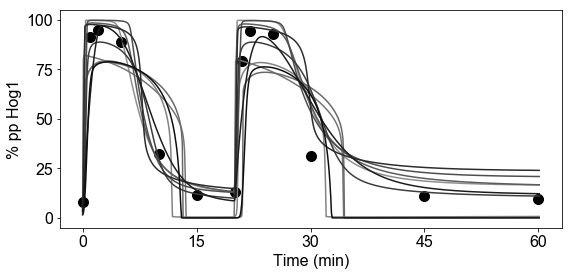

In [38]:
plotting.plt_ramp_behaviors(model_fxns, sorted_thetas_EA, 10, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

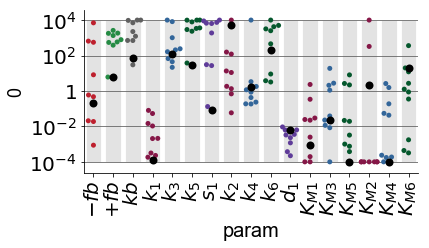

In [32]:
df_top_thetas_EA = pd.DataFrame(sorted_thetas_EA)
df_top_thetas_EA.columns = labelnames

num_plt = 10
df_plt = pd.DataFrame(sorted_thetas_EA[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

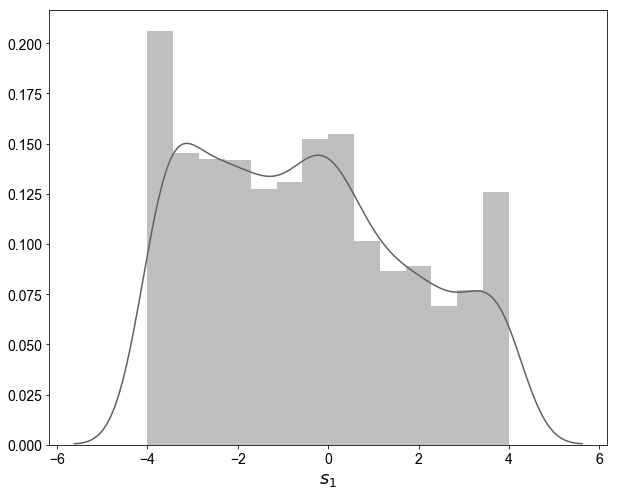

In [21]:
sns.distplot(np.log10(df_top_thetas_EA[labelnames[6]]))

In [42]:
sims_M2c_kb_ea_l = plotting.simdata_to_list(M2c_fxns, M2c_sorted_thetas_EA, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


9% complete.
19% complete.
29% complete.
39% complete.
49% complete.
59% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


69% complete.
79% complete.
89% complete.
99% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


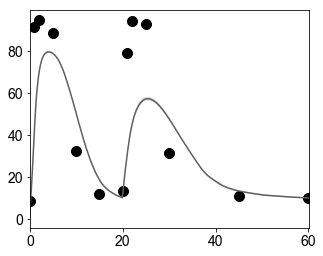

In [46]:
plotting.plt_ramp_cis(sims_M2c_kb_ea_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


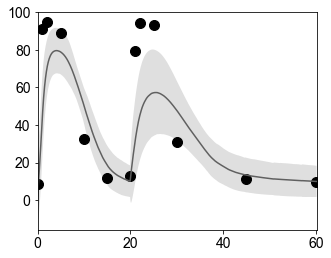

In [47]:
plotting.plt_ramp_cis(sims_M2c_kb_ea_l, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

# SMC

## Try different sizes of EA 

I've been using top 500 and it's worked really well, but here I'm using top 20 so that it runs fast

In [11]:
M2c_new_mses_EA, M2c_new_thetas_EA = recalc_mses(M2c_fxns, M2c_sorted_thetas_EA, exp_data, exp_time, params_constants, initials)

print(M2c_new_mses_EA[:10])

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\o

[1478.14306102 1626.54296106 1690.73008812 1709.54099597 1710.78560993
 1721.51422677 1723.47044062 1758.1880056  1776.88057954 1781.96083847]


No handles with labels found to put in legend.


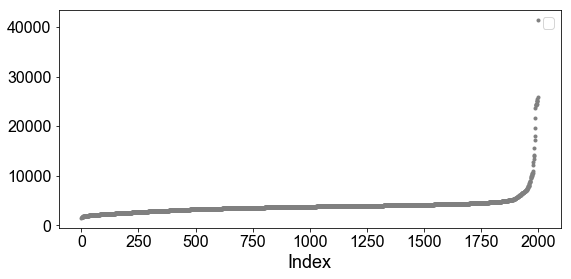

In [13]:
plotting.plt_idx_vs_mse(M2c_new_mses_EA, len(M2c_new_mses_EA))

In [14]:
M2c_EA_thetas_1perc = M2c_new_thetas_EA[:500]
M2c_EA_mses_1perc = M2c_new_mses_EA[:500]

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeserie

Dose: 0 complete.
Dose: 50000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 250000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 450000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

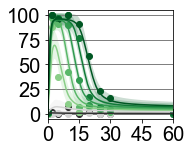

In [55]:
plotting.plt_param_cis(M2c_fxns, M2c_EA_thetas_1perc, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

## Define schedules

I've been messing around with where I start with the schedule and how many schedules to run

In [15]:
# e1, e2, e3, e4 = def_schedules(M2c_EA_mses_1perc)

# print("Best MSE: " + str(M2c_EA_mses_1perc[0]))
# print("Worst MSE: " + str(M2c_EA_mses_1perc[-1]))
# print()
# print("Schedules: " + str(e1),str(e2),str(e3),str(e4))
# print()


Best MSE: 1478.1430610228672
Worst MSE: 3211.9749030904018

Schedules: 3211.9749030904018 2345.0589820566347 1911.601021539751 1694.872041281309



## Fit distributions to parameter distributions

Found that parameter distributions are generally uniform. I think I'll use the parameter sets from the EA to seed the ABC SMC

### Test

In [83]:
data = np.log10(M2c_EA_thetas_1perc[:,5])

In [57]:
from scipy.stats import uniform


C:\Users\sksuzuki\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


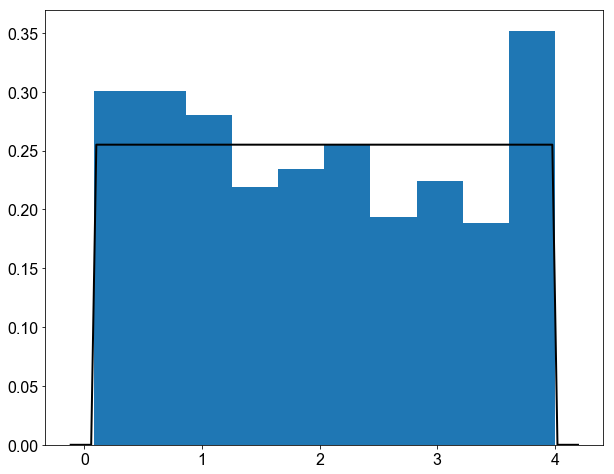

In [84]:
mu, std = uniform.fit(data)
plt.hist(data, normed=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = uniform.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

In [64]:
from scipy.optimize import curve_fit

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [66]:
hist, bin_edges = np.histogram(data, density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
p0 = [1., 2, 1.]

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

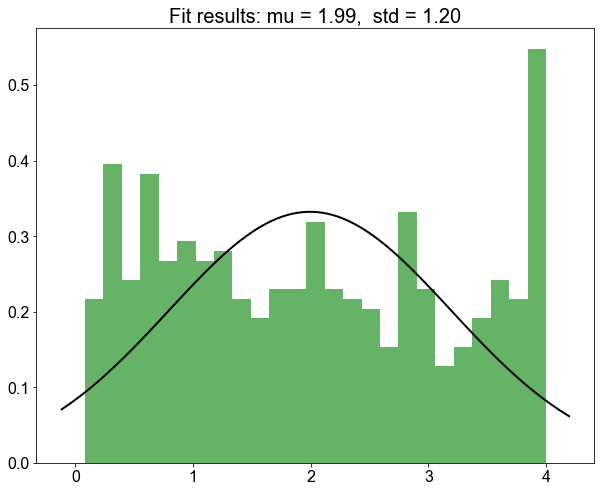

In [69]:
from scipy.stats import norm

mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

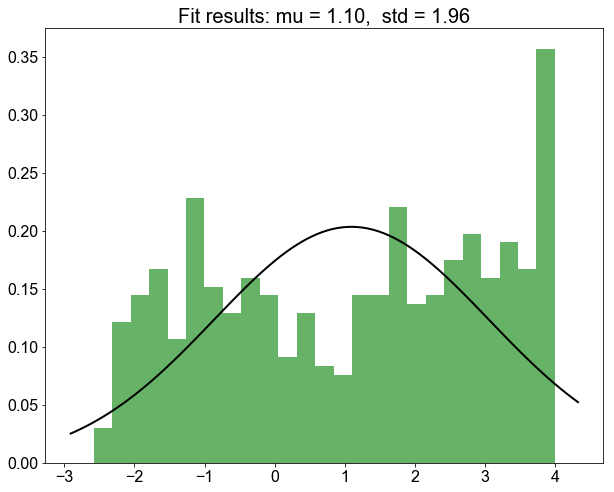

In [70]:
data = np.log10(M2c_EA_thetas_1perc[:,8])
mu, std = norm.fit(data)
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

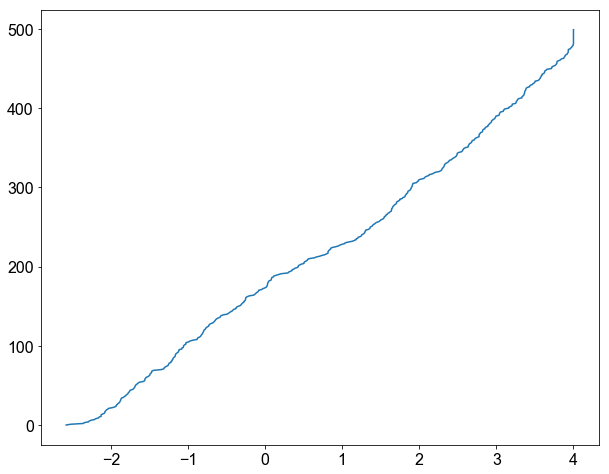

In [78]:
plt.plot( np.sort(data),[x for x in range(len(data))])

In [74]:
# import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

# import theano.tensor as tt
# import shutil


In [75]:
n = 4

mu1 = np.ones(n) * (1. / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1
w2 = (1 - w1)

# ABC SMC

In [155]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/test_M2c/'

all_params, last_params, all_mses, last_mses = model_supp.get_sim_data(folder, num_sims=2000)
print(last_params)

Number of runs collected: 5
Best last gen MSE: 1581.210598992337
Mean last gen MSEs of top 5%: nan
[[1.00545116e-04 1.00000000e-04 1.00000000e+04 4.68456063e-01
  2.16853298e+02 4.06837175e+00 3.96936106e-03 1.55670718e+01
  1.00000000e+04 2.08656467e-02 2.78748077e-03 3.60834295e+03
  8.04573501e-01 7.05215723e-01 8.66212806e-01 1.93375189e+03
  1.00000000e-04]
 [3.09006494e+00 2.37755133e-02 5.14487431e+03 1.90798690e-02
  1.99510760e-01 1.50198389e-02 1.00000007e-04 3.17005725e-02
  1.70509593e-01 3.33412264e-04 5.98017049e+01 7.04483431e-01
  3.70939957e+01 3.14668809e+01 8.39673793e-04 1.27070309e+02
  1.55717125e-04]
 [6.79770873e-04 1.18015272e+01 1.26285163e+01 2.44078302e+00
  1.25812274e+00 6.35461323e+01 8.28926861e+01 3.70303042e-01
  1.15071190e+02 1.12140511e+03 1.00000000e-04 1.46984572e+01
  5.29156633e-03 6.59920783e-03 4.46155692e-01 1.21194110e+02
  4.73761295e+01]
 [1.22223603e+02 2.64866521e+00 4.10864857e+02 1.17038529e-02
  7.60761817e+01 3.97958905e+01 1.1752671

C:\Users\sksuzuki\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [193]:
base1 = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/test_M2c/'
base = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/'
base2 = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/test2_M2c/'

ea_j = h5py.File(base+'test_M2c_0000.hdf5', 'r')
ea_j2 = h5py.File(base+'test2_M2c_0000.hdf5', 'r')

ea_l = h5py.File(base1+'test_M2c_0000.hdf5', 'r')



with ea_j as f:
    ea_thetas = f['thetas']
    ea_mses = f['mses']
#     print(np.array(ea_thetas))
    print(np.array(ea_mses))
    mses, thetas = recalc_mses(model_fxns, ea_thetas, dada, dtime, params_constants, initials, ptpD=False)    
    print(mses)

    
with ea_l as f:
    ea_thetas = f['thetas']
    ea_mses = f['mses']
#     print(np.array(ea_thetas))
    print(np.array(ea_mses))    
    mses, thetas = recalc_mses(model_fxns, ea_thetas, dada, dtime, params_constants, initials, ptpD=False)    
    print(mses)
    
with ea_j2 as f:
    ea_thetas = f['thetas']
    ea_mses = f['mses']
#     print(np.array(ea_thetas))
    print(np.array(ea_mses))    
    mses, thetas = recalc_mses(model_fxns, ea_thetas, dada, dtime, params_constants, initials, ptpD=False)    
    print(mses)

[8551.49065671 9574.22133558 7605.35142806 8244.33480721 8004.71684713]
[2375.6068511576113, 8594.629589638604, 1581.2105989923475, 2430.6803812873286, 2001.1393284712744]
[2375.60685116 8594.62958964 2001.13932847 1581.21059899 2430.68038129]
[2375.6068511576113, 8594.629589638604, 2001.1393284712744, 1581.2105989923475, 2430.6803812873286]
[2375.60685115 8594.62958964 1581.21059899 2430.68038129 2001.13934268]


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[2375.6068511576113, 8594.629589638604, 1581.2105989923475, 2430.6803812873286, 2001.1393284712744]


In [ ]:
mses, thetas = recalc_mses(model_fxns, ea_thetas[:10], dada, dtime, params_constants, initials, ptpD=False)

In [153]:
base1 = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/t200305_M2c_abc_smc/'
base = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/'

ea_j = h5py.File(base+'t200305_M2c_abc_smc_0000.hdf5', 'r')
ea_l = h5py.File(base1+'t200305_M2c_abc_smc_0000.hdf5', 'r')



with ea_j as f:
    ea_thetas = f['thetas']
    ea_mses = f['mses']
    print(np.array(ea_thetas))
    
with ea_l as f:
    ea_thetas = f['thetas']
    ea_mses = f['mses']
    print(np.array(ea_thetas))

[[2.74160876e-04 3.26008646e-01 1.70776644e+01 1.07481413e-03
  8.15222346e+00 1.38506142e+00 6.04469702e-02 5.63716257e-01
  3.25086048e+01 1.32636407e+03 1.66043688e-03 4.86241963e-03
  1.00000000e-04 1.00000000e-04 3.40172209e-03 3.62077158e+00
  2.41884049e+03]
 [5.30883380e+02 8.60860848e+01 1.41093715e-01 2.77183903e-04
  4.39241871e+01 6.21868410e+02 1.04427820e+03 6.72970910e+02
  5.23720034e+03 6.75020387e+00 7.21280882e-04 8.48976946e+02
  7.69935091e-02 5.85932396e-01 2.73557380e+02 6.14861635e+03
  1.73555114e-03]
 [1.07554265e-02 2.76980170e+02 2.64663291e+03 3.91225494e+02
  2.64101106e+03 4.60181857e+03 1.64176761e-02 4.04870808e+03
  1.37274804e+03 1.57881436e-01 1.00000000e-04 6.05527263e+03
  1.02622711e-02 1.99248384e+02 1.69514067e-01 8.41869614e-01
  5.67616953e-04]
 [2.63322009e-04 9.49919916e+01 4.81216187e+02 1.62552148e+03
  6.41725144e+01 1.38237064e+03 1.58739688e+02 5.40078699e+02
  4.04890176e+03 7.31431114e+01 1.61738868e-02 1.00000000e-04
  1.26962002e+01

In [149]:
# print(np.array(ea_thetas[:1]))

last_params[:1]

array([[1.00545116e-04, 1.00000000e-04, 1.00000000e+04, 4.68456063e-01,
        2.16853298e+02, 4.06837175e+00, 3.96936106e-03, 1.55670718e+01,
        1.00000000e+04, 2.08656467e-02, 2.78748077e-03, 3.60834295e+03,
        8.04573501e-01, 7.05215723e-01, 8.66212806e-01, 1.93375189e+03,
        1.00000000e-04]])

In [25]:
list(ea.keys())

['mses', 'thetas']

In [201]:

base = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/200307_M2c_abc/'

ea = h5py.File(base+'200307_M2c_abc_0000.hdf5', 'r')


# with ea_j3 as f:
#     ea_thetas = f['thetas']
#     ea_mses = f['mses']
# #     print(np.array(ea_thetas))
#     print(np.array(ea_mses))
#     mses, thetas = recalc_mses(model_fxns, ea_thetas, dada, dtime, params_constants, initials, ptpD=False)    
#     print(mses)


In [202]:
ea_thetas = ea['thetas']
ea_mses = ea['mses']

In [203]:
ea_thetas = ea['thetas']
ea_mses = ea['mses']

No handles with labels found to put in legend.


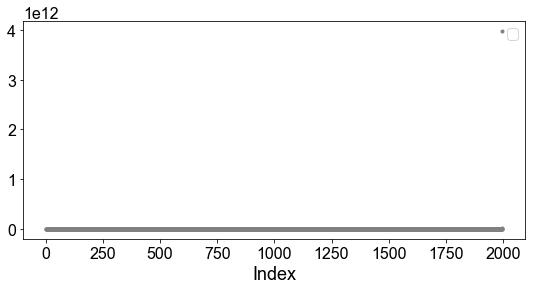

In [204]:
plotting.plt_idx_vs_mse(ea_mses, len(ea_mses))

No handles with labels found to put in legend.


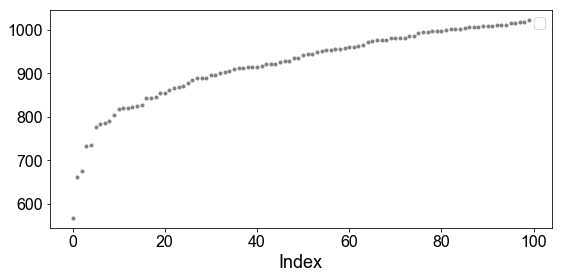

In [205]:
plotting.plt_idx_vs_mse(ea_mses, 100)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

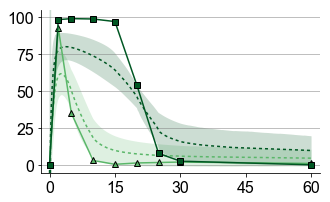

In [206]:
plotting.plt_param_cis(model_fxns, ea_thetas, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

In [208]:
e4 = h5py.File(base+'200307_M2c_abc_0004.hdf5', 'r')
e4_thetas = e4['thetas']
e4_mses = e4['mses']

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

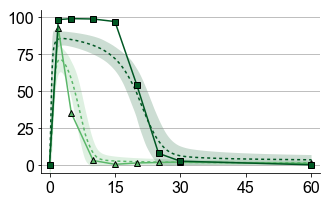

In [209]:
plotting.plt_param_cis(model_fxns, e4_thetas, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

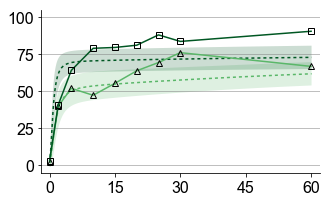

In [33]:
plotting.plt_param_cis(model_fxns, e4_thetas, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

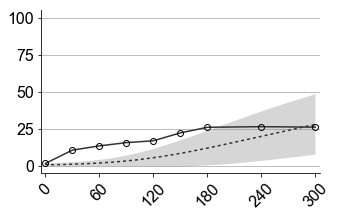

In [210]:
plotting.plt_param_cis(model_fxns, e4_thetas, params_constants, initials,  [0], time2, 2,
                        exp_data=mapk_data_t100a_0, exp_time=mapk_time_t100a_0, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

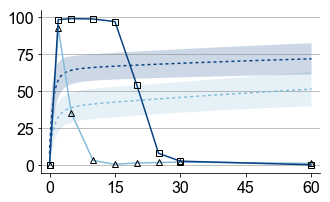

In [38]:
plotting.plt_param_cis(model_fxns, e4_thetas, params_constants, initials,  doses, time, 1,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

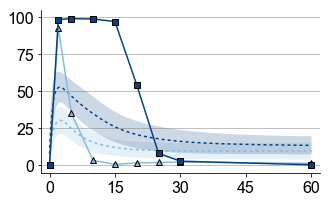

In [39]:
plotting.plt_param_cis(model_fxns, e4_thetas, params_constants, initials,  doses, time, 1,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

In [44]:
test = np.array(ea_mses)
# print(test)

## E4

In [137]:
e4 = h5py.File('C:/Users/sksuzuki/Documents/GitHub/HOG_encoding_feedbacks/python_modules/ABC_SMC/200121_M3c_ea_abc_smc/200121_M3c_ea_abc_smc_0004.hdf5', 'r')

e4_thetas = e4['thetas']
e4_mses = e4['mses']


e4_sorted_mses, e4_sorted_thetas = model_supp.sort_mses_thetas(np.asarray(e4_mses), np.asarray(e4_thetas))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 300000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


<Figure size 720x576 with 0 Axes>

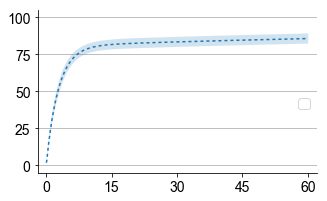

In [9]:
plotting.plt_param_cis(model_fxns, e4_thetas, params_constants, initials,  [300000], time, 2,
                        exp_data=None, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

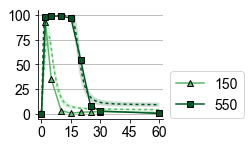

In [18]:
plotting.plt_param_cis(model_fxns, e4_thetas, params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='test03')

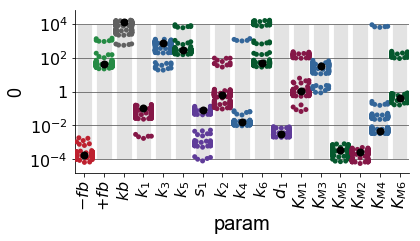

In [58]:
df_top_thetas = pd.DataFrame(e4_sorted_thetas)
df_top_thetas.columns = labelnames

num_plt = 200
df_plt = pd.DataFrame(e4_sorted_thetas[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

## Pca

[0.32236746 0.1462007  0.12772725 0.12458879]
[74.0286887  49.85390559 46.59788903 46.0218365 ]


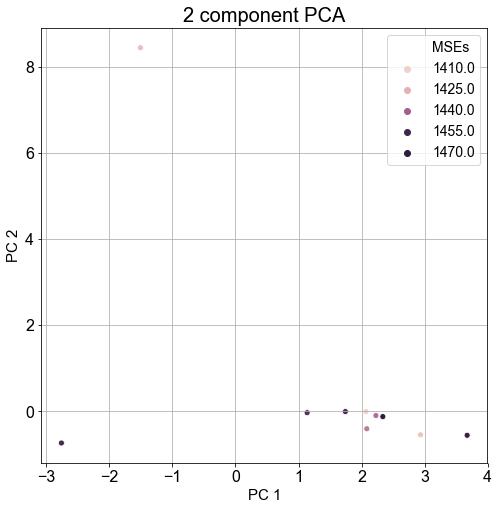

In [110]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

x = df_top_thetas
pca = PCA(n_components=4)
x = StandardScaler().fit_transform(x)

principalComponents = pca.fit_transform(x)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

principalDf = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf['MSEs'] = e4_sorted_mses

num = 10
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
sns.scatterplot('PC 1', 'PC 2', data = principalDf[:num], hue = 'MSEs')
ax.legend()
ax.grid()

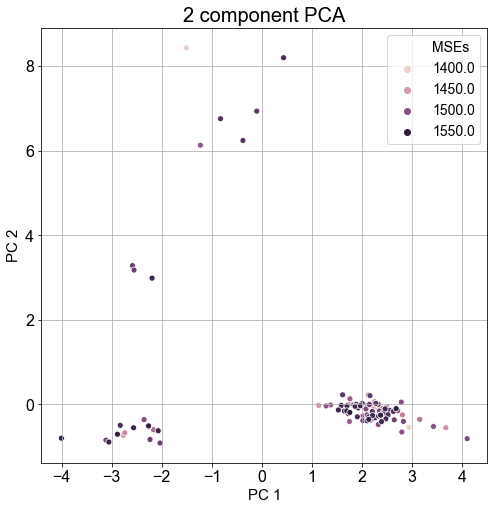

In [107]:
num = 100
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
sns.scatterplot('PC 1', 'PC 2', data = principalDf[:num], hue = 'MSEs')
ax.legend()
ax.grid()

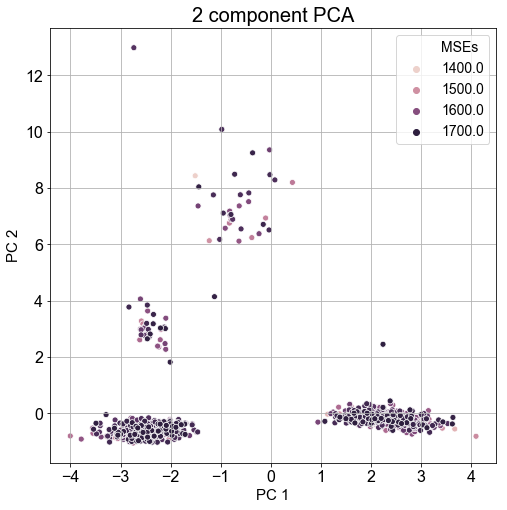

In [108]:
num =1000
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
sns.scatterplot('PC 1', 'PC 2', data = principalDf[:num], hue = 'MSEs')
ax.legend()
ax.grid()

In [149]:
inhib_sims = plotting.inhibdata_to_list(model_fxns, e4_sorted_thetas[:10], params_constants, initials, time, 2, sig=450000, run_type=['ramp'], ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


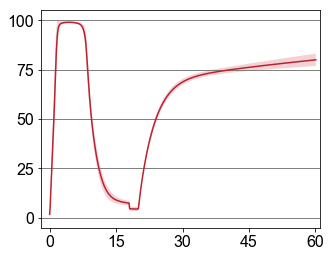

In [150]:
plotting.plt_inhib_cis(inhib_sims, time, 2, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


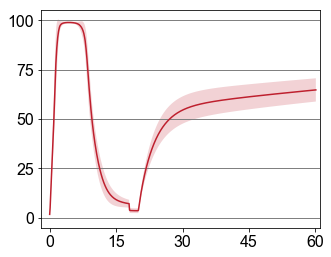

In [134]:
plotting.plt_inhib_cis(inhib_sims, time, 2, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


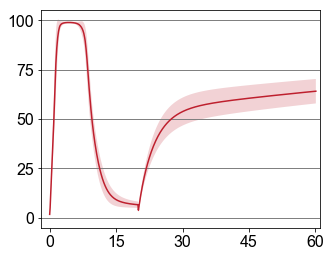

In [128]:
plotting.plt_inhib_cis(inhib_sims, time, 2, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


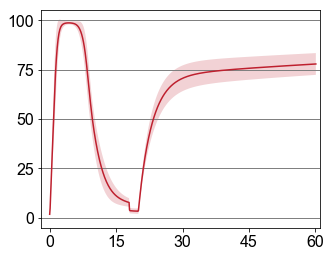

In [120]:
plotting.plt_inhib_cis(inhib_sims, time, 2, ci="sd") #t>5 with ramp

In [35]:
inhib_sims = plotting.inhibdata_to_list(model_fxns, e4_thetas[:10], params_constants, initials, time, 3, sig=450000, run_type=['ramp'], ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


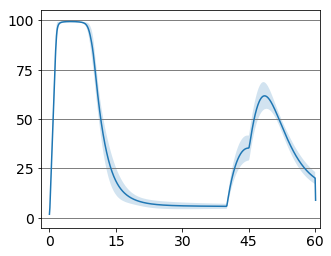

In [30]:
plotting.plt_inhib_cis(inhib_sims, time, 2, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


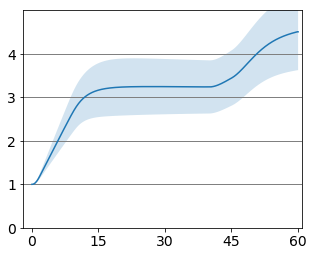

In [36]:
plotting.plt_inhib_cis(inhib_sims, time, 3, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


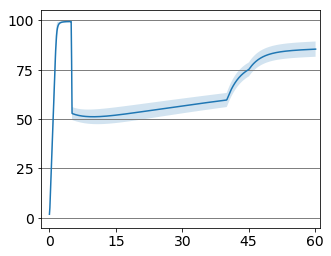

In [32]:
plotting.plt_inhib_cis(inhib_sims, time, 2, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


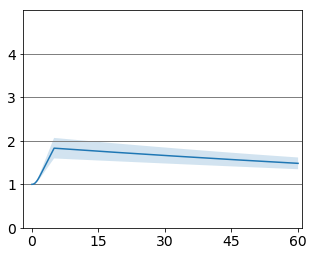

In [34]:
plotting.plt_inhib_cis(inhib_sims, time, 3, ci="sd") #t>5 with ramp

In [47]:
inhib_sims = plotting.inhibdata_to_list(model_fxns, e4_thetas[:10], params_constants, initials, time, 3, sig=450000, run_type=['ramp'], ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


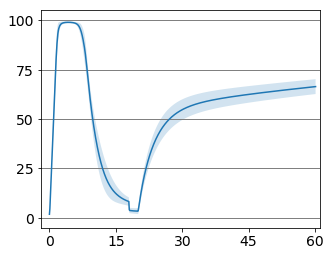

In [45]:
plotting.plt_inhib_cis(inhib_sims, time, 2, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


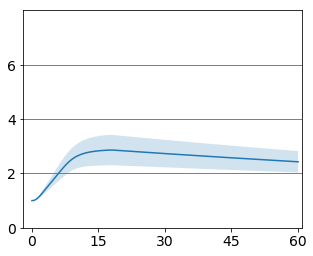

In [48]:
plotting.plt_inhib_cis(inhib_sims, time, 3, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


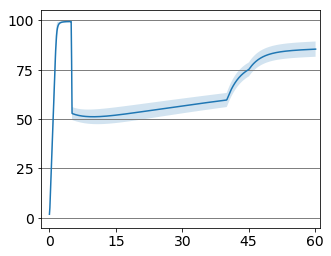

In [32]:
plotting.plt_inhib_cis(inhib_sims, time, 2, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


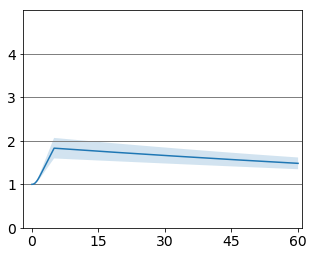

In [34]:
plotting.plt_inhib_cis(inhib_sims, time, 3, ci="sd") #t>5 with ramp